## Introduction
In this exercise, you'll add dropout to the Spotify model from Exercise 4 and see how batch normalization can let you successfully train models on difficult datasets.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import tensorrt

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


## 1) Add Dropout to Spotify Model
Here is the last model from Exercise 4. Add two dropout layers, one after the Dense layer with 128 units, and one after the Dense layer with 64 units. Set the dropout rate on both to 0.3.

```python
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])
```

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = input_shape),
    layers.Dropout(rate = 0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1)
])

Now run this next cell to train the model see the effect of adding dropout.

Minimum Validation Loss: 0.1880


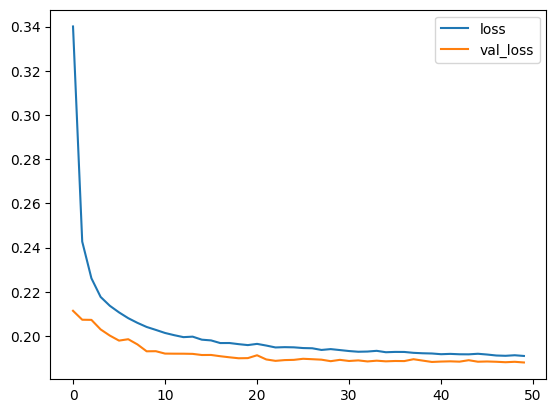

In [7]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

## 2) Evaluate Dropout
Recall from Exercise 4 that this model tended to overfit the data around epoch 5. Did adding dropout seem to help prevent overfitting this time?


<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
    <title></title>
    <style>
      /* Whatever that is inside this <style> tag is all styling for your markup / content structure.
      /* The . with the boxed represents that it is a class */
      .boxed {
        background: #ADD8E6;
        color: black;
        border: 3px solid #535353;
        margin: 0px auto;
        width: 800px;
        padding: 10px;
        border-radius: 5px;
      }
    </style>
  </head>
  <body>
    <!-- This is the markup of your box, in simpler terms the content structure. -->
    <div class="boxed" style = "text-align: justify">
       From the learning curves, you can see that the validation loss remains near a constant minimum even though the training loss continues to decrease. So we can see that adding dropout did prevent overfitting this time. Moreover, by making it harder for the network to fit spurious patterns, dropout may have encouraged the network to seek out more of the true patterns, possibly improving the validation loss some as well.
    </div>
  </body>
</html>


Now, we'll switch topics to explore how batch normalization can fix problems in training.

Load the Concrete dataset. We won't do any standardization this time. This will make the effect of batch normalization much more apparent.

In [8]:
import pandas as pd

concrete = pd.read_csv('concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]


ValueError: in user code:

    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 18), found shape=(None, 8)
